<a href="https://colab.research.google.com/github/numagic/lumos/blob/update_colab_example/tutorials/colab/Brachistochrone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
Usually it is recommended to use lumos with the docker image it provides. But we can also run `lumos` with conda environment.

Google Colab provides free GPU and TPU VMs that one could use with jupyter notebook style UI, and this is what we're going to use.

To set up the environment, we'll:
1) install conda on google colab using `condacolab`
2) clone the `lumos` git repo, and setup the conda environment (this will be replaced by pip install in the future)
3) run laptime simulation example

# Install Conda on Google Colab

<!-- By Jaime Rodríguez-Guerra <@jaimergp>. Last modified 2021.08.04 -->

`condacolab` simplifies the setup as much as possible, but there are some gotchas.

**⚠️ Read this before continuing!**

* The `condacolab` commands need to be run the first Code cell!
* Once you run `condacolab.install()`, the Python kernel will be restarted. This is **normal and expected**. After that, you can continue running the cells below like normal.
* Do not use the `Run all` option. Run the `condacolab` cell _individually_ and wait for the kernel to restart. **Only then**, you can run all cells if you want.
* You can only use the `base` environment. Do not try to create new ones; instead update `base` with either:
  * `conda install <packages>`
  * `conda env update -n base -f environment.yml`
* If you want to use GPUs, make sure you are using such an instance before starting!
* If you get an error, please raise an issue [here](https://github.com/jaimergp/condacolab/issues).

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:41
🔁 Restarting kernel...


In [ ]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [2]:
# We could set up the dependencies using enviornment.yml
# !git clone https://github.com/numagic/lumos
# %cd /content/lumos
# !git checkout dev
# !conda env update -n base -f environment.yml

# Or... we could direclty install them so we don't need to clone the repo
# TODO: make dependency automatic -> this would require conda as there are
# non-python dependencies
!conda install -c conda-forge cyipopt
!pip install jax[cpu] casadi pyarrow pandas matplotlib
!pip install numagic-lumos==0.0.2rc5

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

# All requested packages already installed.

Retrieving notices: ...working... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Run Brachistochrone example with automatic differentiation

Note that unfortunately colab does not show the stdout printed to the terminal, therefore the user must use the command tabs: 'Runtime' -> 'View runtime logs' to see the stdout outputs, such as those from IPOPT.

INFO:lumos.optimal_control.scaled_mesh_ocp:Triggering jax JIT
INFO:lumos.optimal_control.nlp:Time NLP execution
INFO:lumos.optimal_control.nlp:time.objective: 0.000335
INFO:lumos.optimal_control.nlp:time.gradient: 0.000023
INFO:lumos.optimal_control.nlp:time.hessian: 0.000021
INFO:absl:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO:absl:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:absl:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:absl:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
INFO:lumos.optimal_control.nlp:model_algebra.constraints: 0.000903
INFO:lumos.optimal_control.nlp:model_algebra.jacobian: 0.000427
INFO:lumos.optimal_control.nlp:model_algebra.hessian: 0.000429
INFO:lumos.optimal_control.nlp:continuity.constraints: 0.001217
INFO:lumos.optimal_control.n

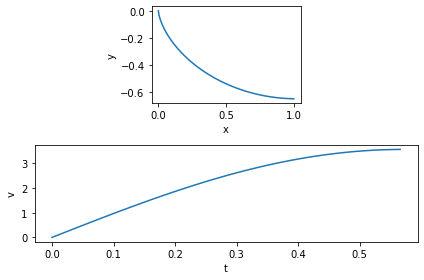

In [3]:
%matplotlib inline
import logging
import sys
import numpy as np
from typing import Any, Dict

from matplotlib import pyplot as plt

import lumos.numpy as lnp
from lumos.models.base import StateSpaceModel, StateSpaceModelReturn, state_space_io
from lumos.optimal_control.scaled_mesh_ocp import ScaledMeshOCP
from lumos.optimal_control.config import (
    BoundaryConditionConfig,
    BoundConfig,
)

@state_space_io(states=("v", "x", "y"), inputs=("theta",), outputs=("theta",))
class Brachistochrone(StateSpaceModel):
    """The Brachistochrone model formulatd in the time domain"""

    def __init__(
        self, model_config: Dict[str, Any] = {}, params: Dict[str, Any] = {},
    ):
        super().__init__(model_config=model_config, params=params)

    def forward(
        self,
        states: Dict[str, float],
        inputs: Dict[str, float],
        mesh: float = 0.0,  # time invariant model
    ) -> StateSpaceModelReturn:
        params = self._params
        theta = inputs["theta"]
        v = states["v"]
        v_dot = -params["gravity"] * lnp.sin(theta)

        dx_dt = lnp.cos(theta) * v
        dy_dt = lnp.sin(theta) * v

        # Assemble result
        states_dot = self.make_dict(group="states_dot", v=v_dot, x=dx_dt, y=dy_dt,)
        outputs = self.make_dict(group="outputs", theta=theta)
        return self.make_state_space_model_return(
            states_dot=states_dot, outputs=outputs
        )

    @classmethod
    def get_default_params(self) -> Dict[str, Any]:
        return {"gravity": 9.81}


def solve_with_ad(dx, dy, backend):
    model = Brachistochrone()
    sim_config = ScaledMeshOCP.get_sim_config(
        boundary_conditions=(
            BoundaryConditionConfig(0, "states", "x", 0.0),
            BoundaryConditionConfig(0, "states", "y", 0.0),
            BoundaryConditionConfig(0, "states", "v", 0.0),
            BoundaryConditionConfig(-1, "states", "x", dx),
            BoundaryConditionConfig(-1, "states", "y", dy),
        ),
        bounds=(
            BoundConfig("global", "mesh_scale", (0.01, 10.0)),
            BoundConfig("inputs", "theta", (-np.pi / 2, np.pi / 2)),
        ),
        num_intervals=49,
        hessian_approximation="exact",
        backend=backend,
        # transcription="LGR",
        # is_condensed=False,
    )
    ocp = ScaledMeshOCP(model=model, sim_config=sim_config)
    # Very casual initial guess -- just all zeros.
    x0 = np.zeros(ocp.num_dec)
    solution, info = ocp.solve(
        x0,
        max_iter=200,
        print_level=1,
        print_timing_statistics="no",
        derivative_test="none",
    )
    vars = ocp.dec_var_operator.unflatten_var(solution)
    op = ocp.dec_var_operator
    final_t = ocp.objective(solution)
    y = vars.states[:, op.get_var_index_in_group("states", "y")]
    x = vars.states[:, op.get_var_index_in_group("states", "x")]
    v = vars.states[:, op.get_var_index_in_group("states", "v")]
    theta = vars.states[:, op.get_var_index_in_group("inputs", "theta")]
    t = ocp.get_mesh_from_scale(vars.mesh_scale)
    min_y = np.min(y)
    logger.info(f"minimum height {min_y:.3f}")
    logger.info(f"final time {final_t:.3f}")
    return t, x, y, v, theta

logger = logging.getLogger()
logger.setLevel(logging.INFO)
t, x, y, v, theta = solve_with_ad(1.0, -0.65, backend="jax")

# Visualize the result
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.plot(x, y)
ax1.set_aspect('equal', adjustable='box')

ax2 = fig.add_subplot(212)
ax2.set_xlabel('t')
ax2.set_ylabel('v')
ax2.plot(t, v)

fig.tight_layout()